# EDA- Option 1: Business Names

Dataset: https://www.kaggle.com/datasets/peopledatalabssf/free-7-million-company-dataset

Derive insights about Business Names. For this analysis, I will ignore inter-relationships between fields that do not involve the Business Name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import nltk
import re
import wordcloud

#from textblob import TextBlob
DATASET = './dataset/companies_sorted.csv'

Read in data file and view first few rows.

In [172]:
df = pd.read_csv(DATASET)
df.head()

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


Check Pandas DataFrame info. There are 11 columns. The first column appears to be a former index column. Most of the columns are text. Numerical columns are `year founded`, `current employee estimate`, `total employee estimate`.

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB


This is a massive dataset. There are **7,173,425 records**.

**Drop the `Unnamed: 0` column** from dataset. Also drop duplicates (if they exist).

In [174]:
df.drop(columns=['Unnamed: 0'], inplace=True)

#drop missing names and industries
df.drop(df.index[df.name.isna()], inplace=True)
#df.drop(df.index[df.industry.isna()], inplace=True)

#Drop Duplicates
original_size = len(df)
df.drop_duplicates(inplace=True)
print(f'Dropped {original_size-len(df)} duplicate records')

Dropped 0 duplicate records


View percentage of missing data for each column

Text(0.5, 0, '%')

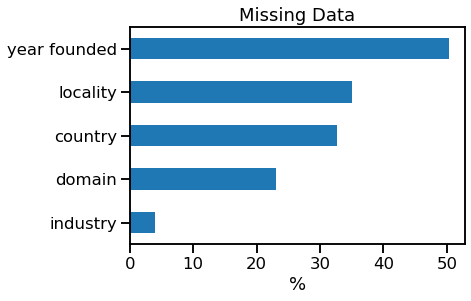

In [176]:
#Percentage missing data for each column
missing_data = 100 * df.isna().sum() / len(df)
missing_data = missing_data[missing_data>0]
missing_data = missing_data.sort_values()
missing_data.plot.barh();
plt.title('Missing Data')
plt.xlabel('%')

Since the dataset is so massive, I'm going to **drop all incomplete records** in order to reduce the total size.

In [177]:
original_size = len(df)
df.dropna(inplace=True)
new_size = len(df)
print(f'Dropped {original_size-new_size} incomplete records.')
print(f'Dataset now has {new_size} records.')

Dropped 4638247 incomplete records.
Dataset now has 2535176 records.


In [5]:
# Also going to drop data for companies that have a Year founded in the future... potential data corruption
df = df[df['year founded']<=2022]

**Company Names NLP steps:**

* Store original 'unedited' company name into field called `original name`
* Keep only ascii characters
* Remove punctuation from company names
* Strip excess white space
* Tokenize the Company names
* Remove stopwords (things like 'a', 'the', etc)

In [179]:
#Generate stopwords list from nltk and make a function to remove the stopwords from a tokenized list of words.

#Use nltk stopwords lists for the selected languages below
stopwords = []
languages = ['english', 'french', 'spanish', 'portuguese']
for language in languages:
    stopwords = stopwords + nltk.corpus.stopwords.words(language)
    
stopwords = list(set(stopwords))

#stopwords = list(set([word.encode('ascii', 'ignore').decode('ascii') for word in nltk.corpus.stopwords.words()]))

def remove_stopwords(tokenized_list, stopwords=stopwords):
    return [token for token in tokenized_list if token not in stopwords]

In [34]:
#Since this is a text analysis, make everything lowercase for comparisons, only use ascii characters, remove stopwords

#Save original text of name for comparison if needed
df['original name'] = df['name']

#Only keep ascii characters
for col in ['name', 'domain', 'industry', 'locality', 'country']:
    df[col] = df[col].str.lower().str.encode('ascii', 'ignore').str.decode('ascii')
    
#Replace & with ' and ' and remove other punctuation in 'name' column
df['name'] = df['name'].apply(lambda x: re.sub('&', 'and', x)).apply(lambda x: re.sub('[^\w\s]','', x))

#Replace all instances of multiple whitespaces in name column with a single white space
df['name'] = df['name'].apply(lambda x: re.sub('\s+',' ', x))

#Tokenize the company name
df['name tokenized'] = df['name'].apply(lambda x: x.split(' '))
#Remove stopwords
df['name tokenized'] = df['name tokenized'].apply(remove_stopwords)

#Calculate word count in company name
df['word count'] = df['name tokenized'].apply(lambda x: len(x))

**Store pre-processed dataset for use later**

In [41]:
#Store cleaned subset of data for future use if needed
df.to_csv('./dataset/companies_sorted_subset_cleaned.csv', index=False)

# EDA

In [2]:
from ast import literal_eval
df = pd.read_csv('./dataset/companies_sorted_subset_cleaned.csv', converters={'name tokenized': literal_eval})
df.describe()

,year founded,current employee estimate,total employee estimate,word count
count,2.534521e+06,2.534521e+06,2.534521e+06,2.534521e+06
mean,2.000494e+03,2.391868e+01,5.722879e+01,2.652700e+00
std,2.174511e+01,5.420570e+02,1.362642e+03,1.251953e+00
min,1.451000e+03,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.997000e+03,1.000000e+00,2.000000e+00,2.000000e+00
50%,2.008000e+03,2.000000e+00,4.000000e+00,3.000000e+00
75%,2.013000e+03,7.000000e+00,1.400000e+01,3.000000e+00
max,2.103000e+03,2.740470e+05,7.169060e+05,1.600000e+01


In [3]:
df['industry'].value_counts()

information technology and services    205276
marketing and advertising              157848
management consulting                   84495
computer software                       82844
construction                            81648
                                        ...  
ranching                                  510
railroad manufacture                      453
tobacco                                   401
nonprofit organization management         121
legislative office                         92
Name: industry, Length: 148, dtype: int64

In [4]:
df['country'].value_counts()

united states               1024987
united kingdom               211709
canada                       115112
netherlands                  104505
india                         91047
                             ...   
samoa                             1
central african republic          1
saint helena                      1
tonga                             1
eritrea                           1
Name: country, Length: 231, dtype: int64

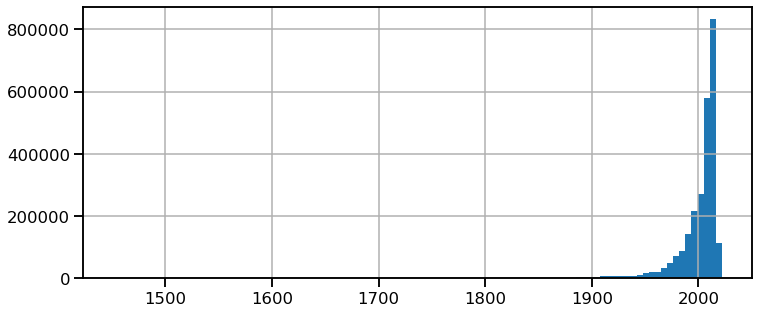

In [6]:
plt.figure(figsize=(12,5))
df['year founded'].hist(bins=100);

## Number of Words in Company Name compared to Size of Company

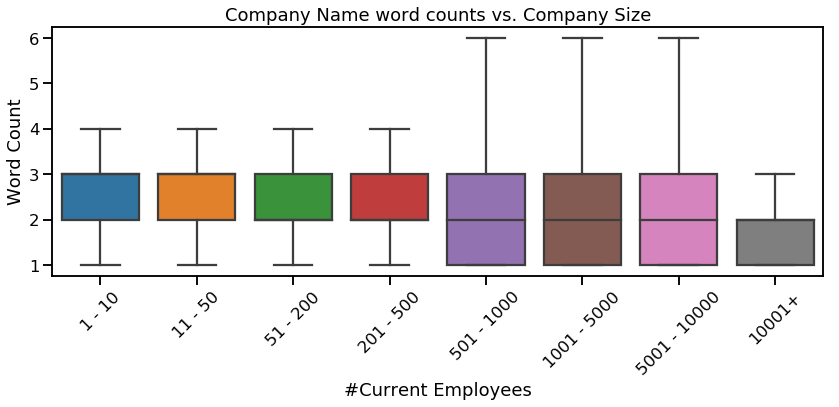

In [15]:
x = 'size range'
y = 'word count'

sorted_order = list(df[x].unique())
sorted_order.reverse()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x=x, y=y, order=sorted_order, showfliers=False)
plt.xticks(rotation=45);
plt.xlabel('#Current Employees')
plt.ylabel('Word Count')
plt.title('Company Name word counts vs. Company Size')
plt.tight_layout()
plt.savefig('./charts/Word Count vs Company Size.png');

The larger that a company is, the fewer words are used in it's name. This makes sense in general because as companies become massive, they are more well-known and do not require extra descriptive words. They are known by a only 1 or 2 words or acronyms.

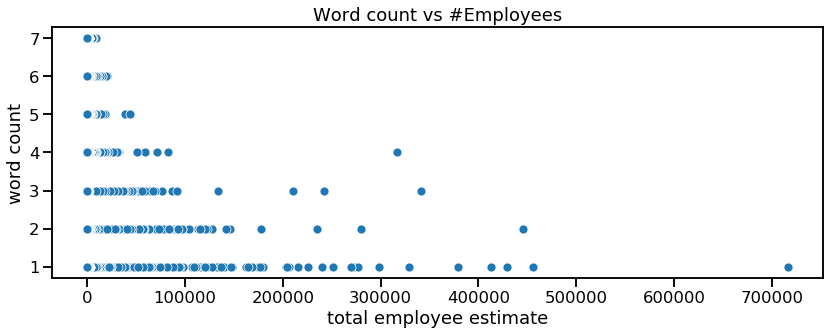

In [16]:
x = 'total employee estimate'
y = 'word count'

df_sel = df[df['word count']<=7]

plt.figure(figsize=(12,5))
sns.scatterplot(data=df_sel, x=x, y=y)
plt.title('Word count vs #Employees')
plt.tight_layout()
plt.savefig('./charts/Word Count vs Company Size scatter.png')

This chart allows for better visualization of the spread. Again, larger companies have fewer words in their name. Smaller companies seem to have any number of words.

## Number of Words in Company Name by Country

For some quick analysis, drop countries with low representation (less than 1000 companies). This still leaves 80 countries in the list.

In [17]:
df_country_counts = df['country'].value_counts()
countries_to_keep = list(df_country_counts[df_country_counts > 1000].index)

df = df[df['country'].isin(countries_to_keep)]

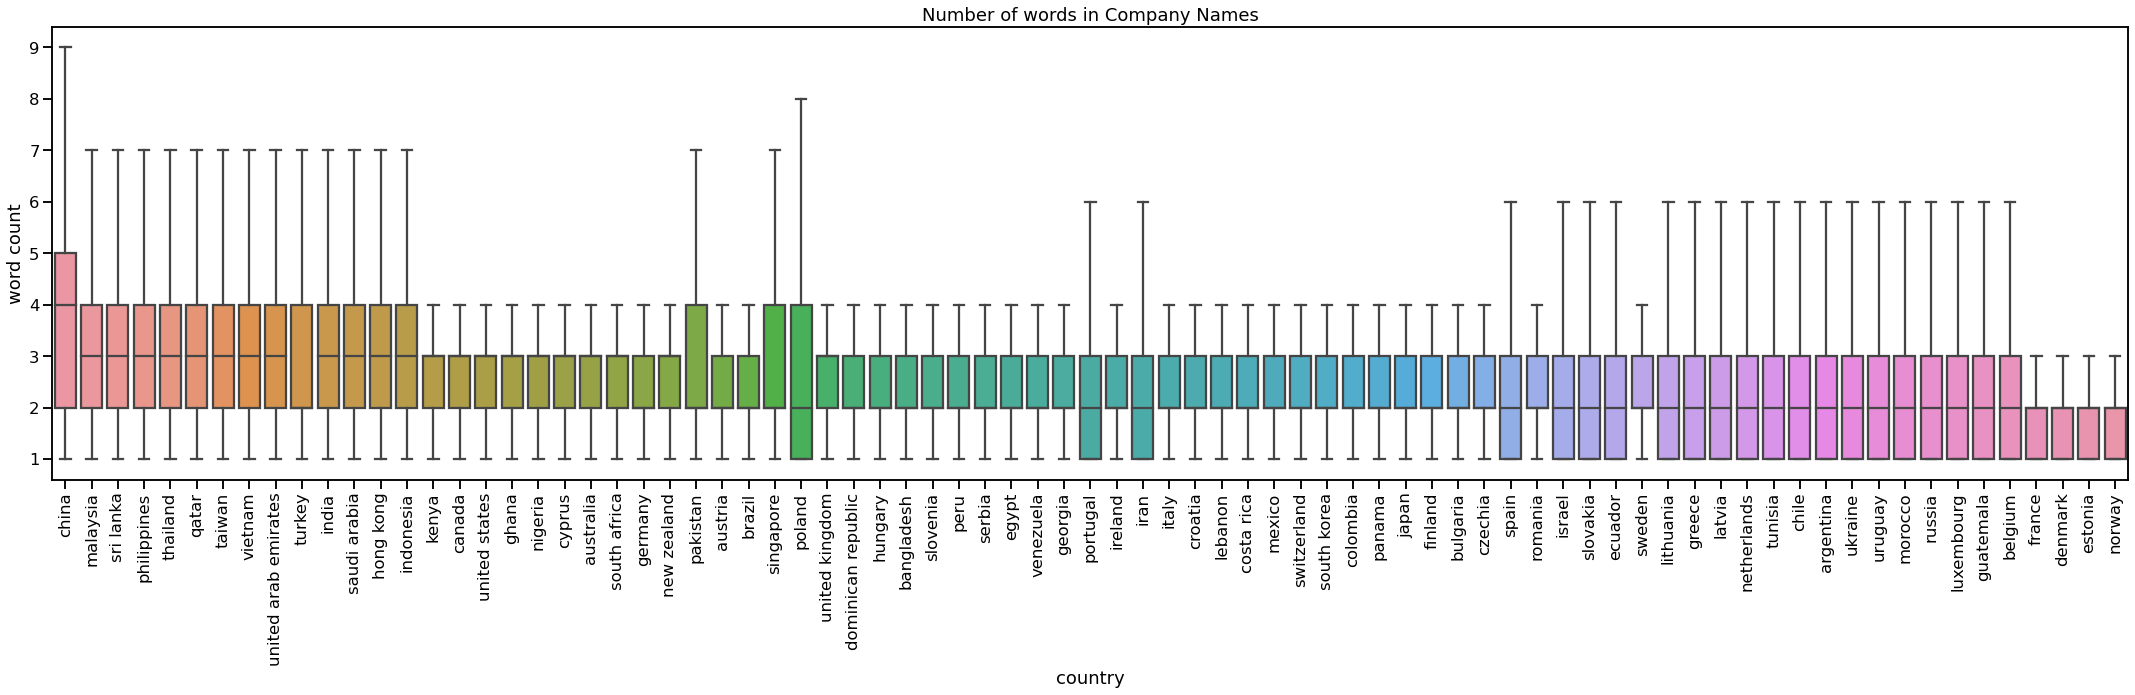

In [288]:
sorted_index = list(df.groupby('country')['word count'].mean().sort_values().index)
sorted_index.reverse()

plt.figure(figsize=(30,10))
plt.title('Number of words in Company Names')
sns.boxplot(data=df, x='country', y='word count', showfliers=False, order=sorted_index)
plt.xticks(rotation=90);
plt.tight_layout()
plt.savefig('./charts/Num Words by Country.png');

The countries are sorted by average word count. China has the lonest company names followed by several other Asian countries. Scandinavian countries are on the shorter side.

## Most common words in company names (top 20 industries)

From the top 20 industries in the dataset, can we see which words are most common in company names?

In [8]:
top_industries = list(df['industry'].value_counts()[0:20].index)
top_industries

['information technology and services',
 'marketing and advertising',
 'management consulting',
 'computer software',
 'construction',
 'internet',
 'real estate',
 'financial services',
 'health, wellness and fitness',
 'design',
 'non-profit organization management',
 'education management',
 'retail',
 'hospital & health care',
 'staffing and recruiting',
 'professional training & coaching',
 'food & beverages',
 'law practice',
 'architecture & planning',
 'automotive']

In [90]:
from nltk import FreqDist

#Generate a dictionary containing the frequency of words for each industry
industry_word_map = {}

for industry in top_industries:
    companies = df[df['industry']==industry]['name tokenized']
    fdist = FreqDist(companies.sum())
    industry_word_map[industry] = pd.DataFrame(fdist.most_common(100), columns=['word', 'frequency'])
    industry_word_map[industry]['frequency %'] = 100*industry_word_map[industry]['frequency'] / len(companies)
    industry_word_map[industry].to_csv(f'./industry_words/{industry} frequent words.csv')

In [10]:
#industry_word_map = {}

#for industry in top_industries:
#    industry_word_map[industry] = pd.read_csv(f'./industry_words/{industry} frequent words.csv')
    

#### View bar chart for each industry

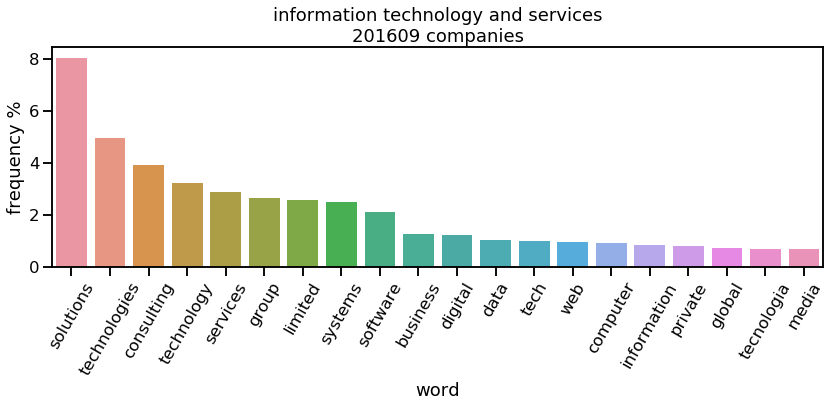

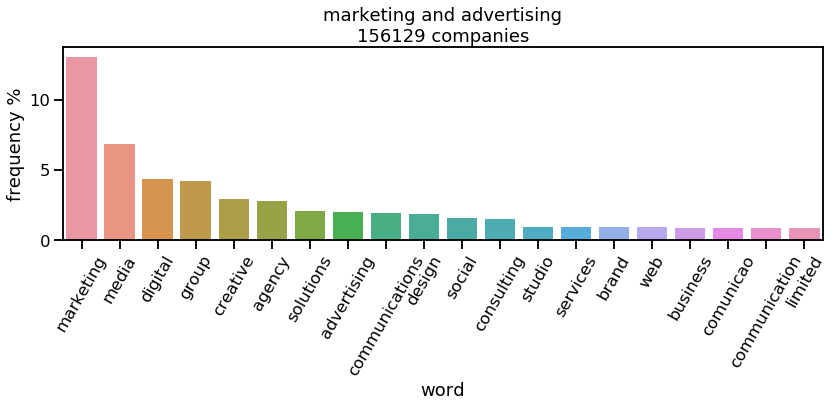

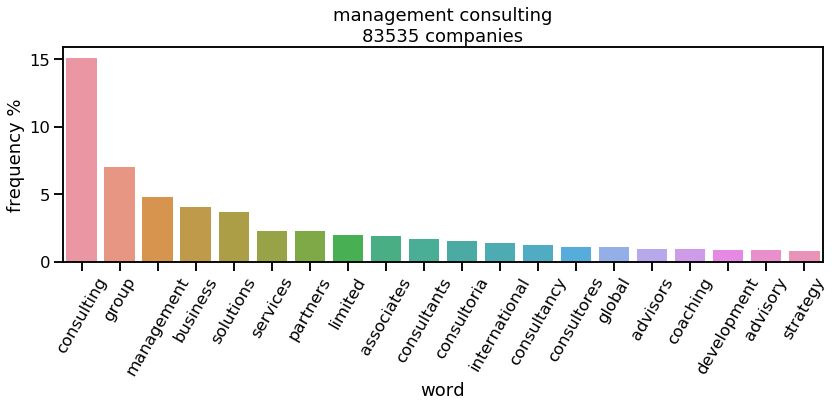

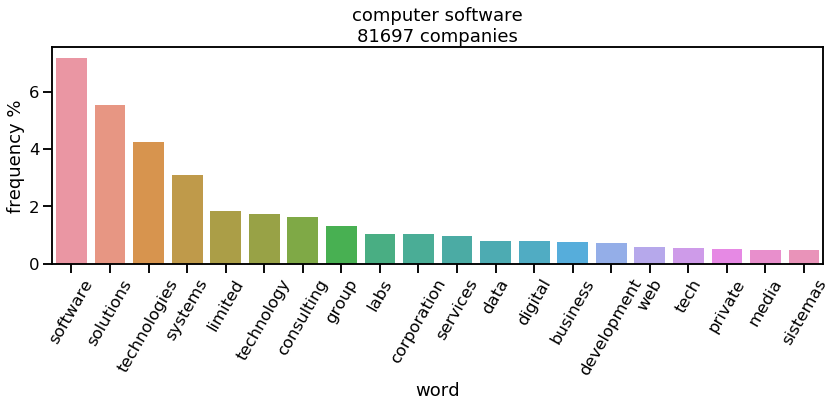

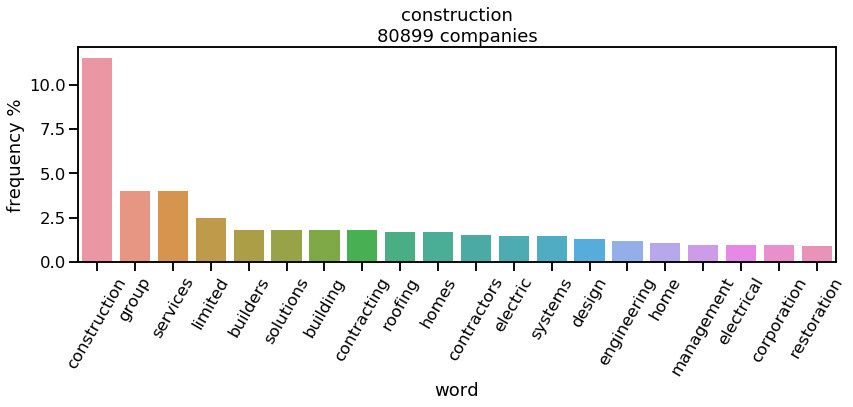

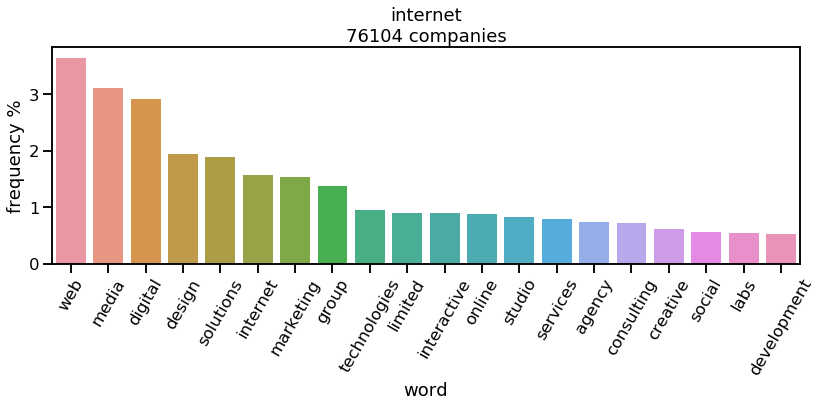

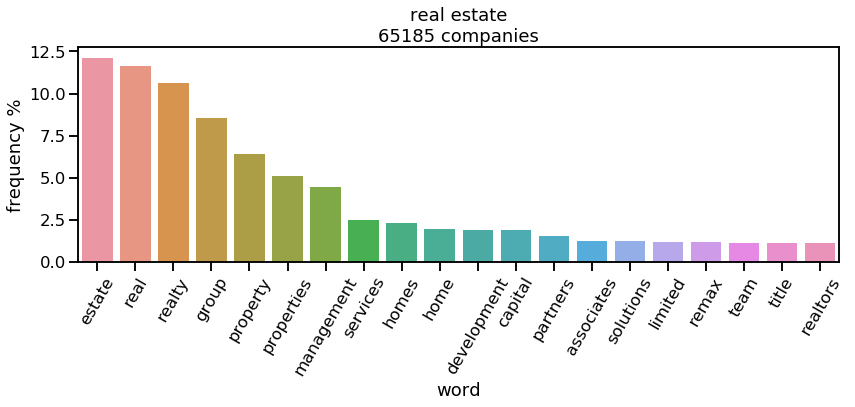

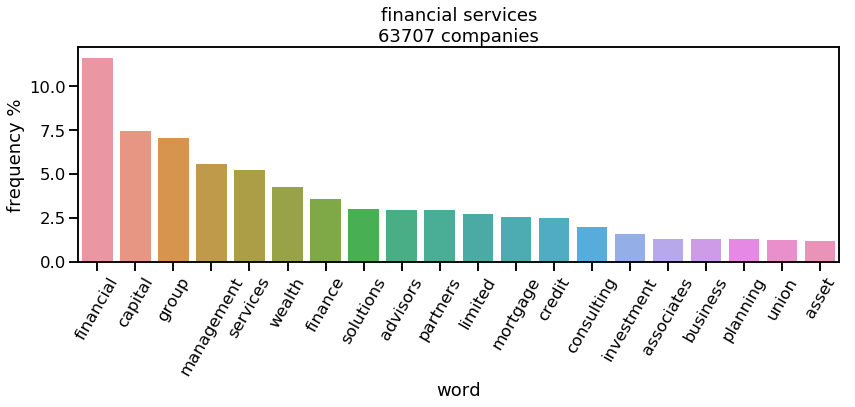

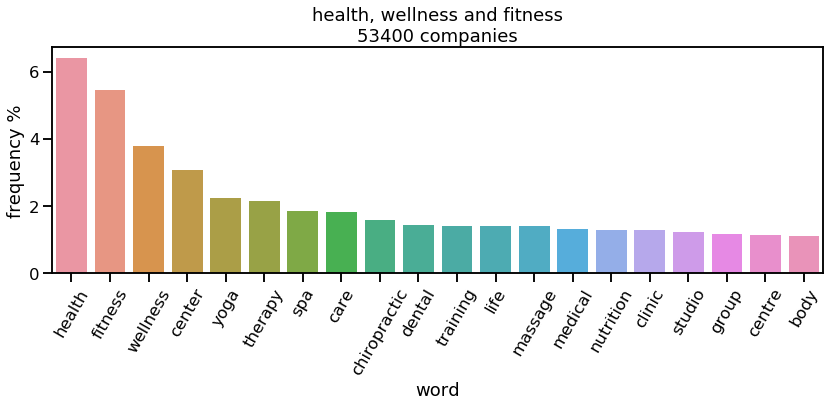

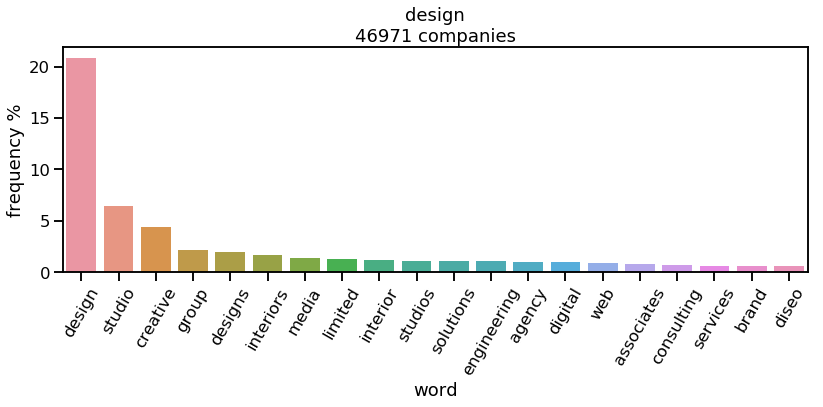

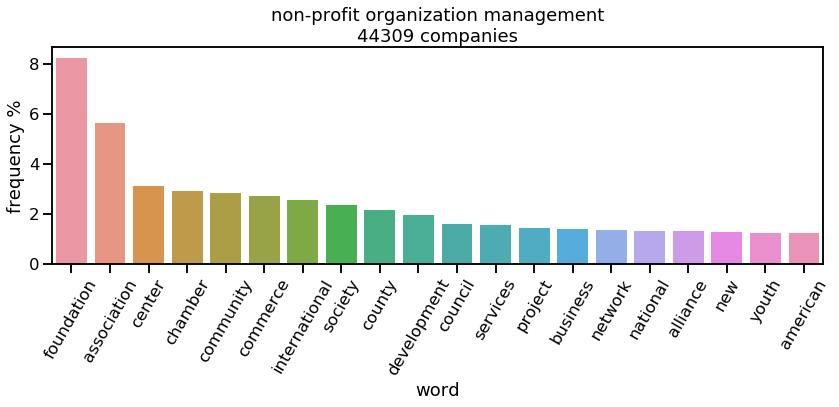

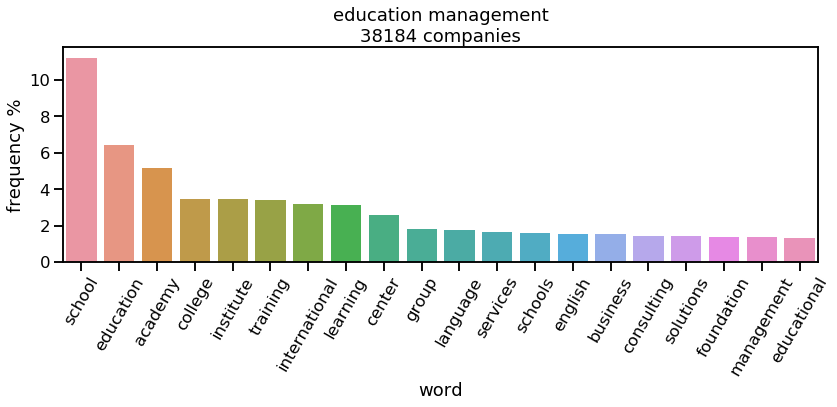

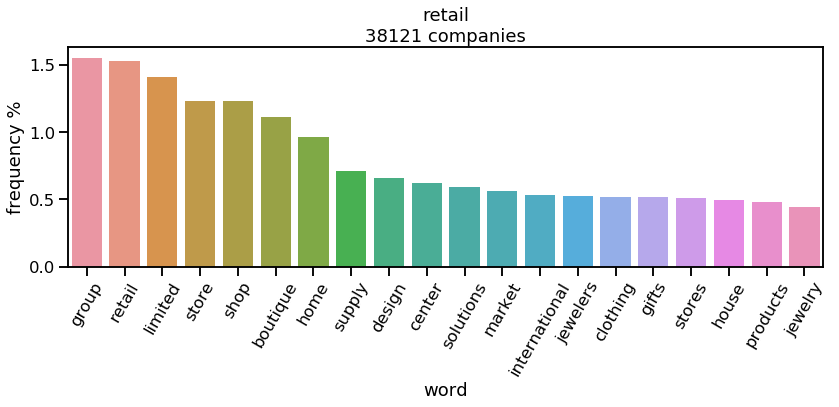

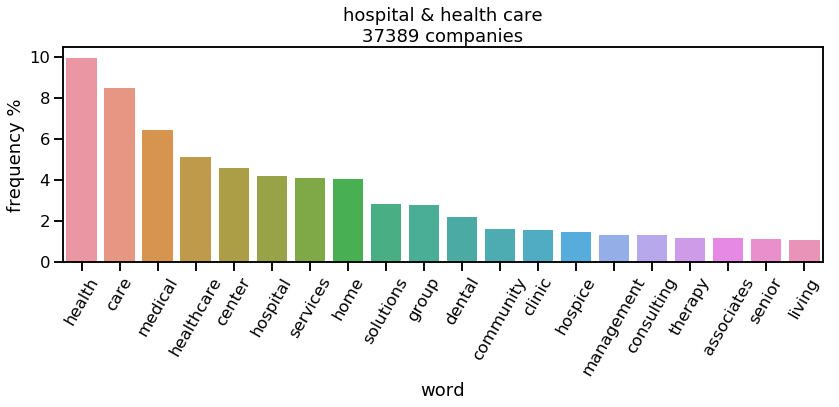

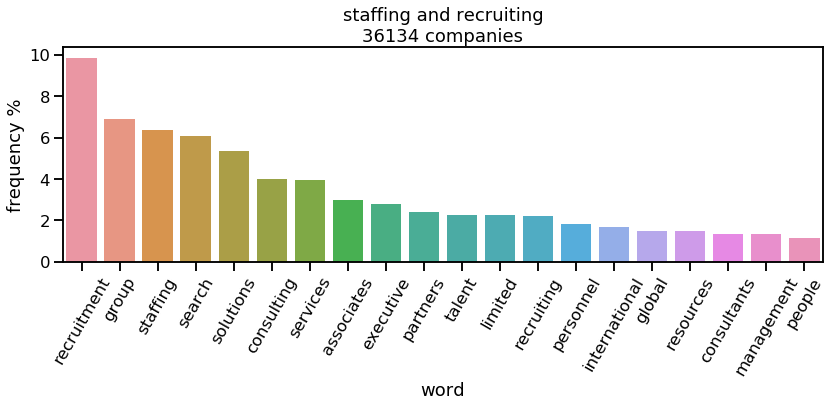

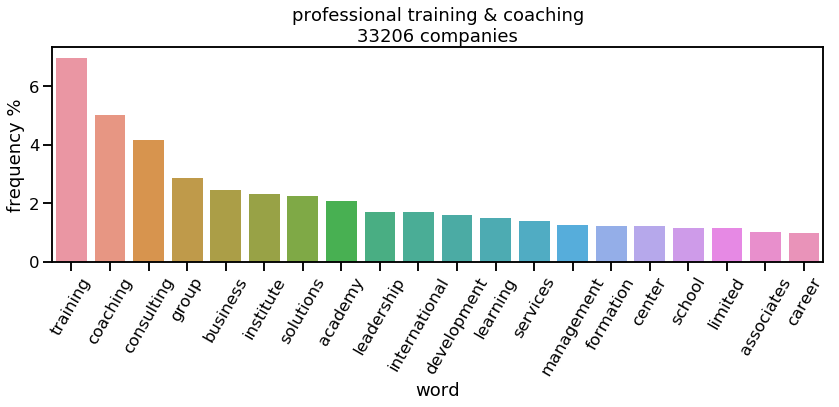

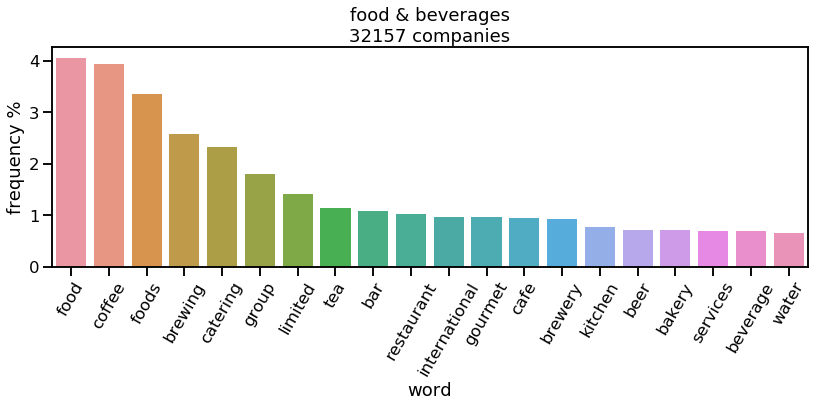

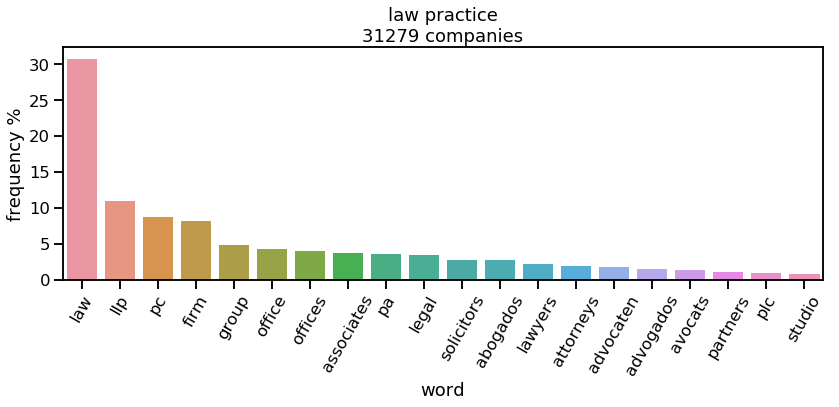

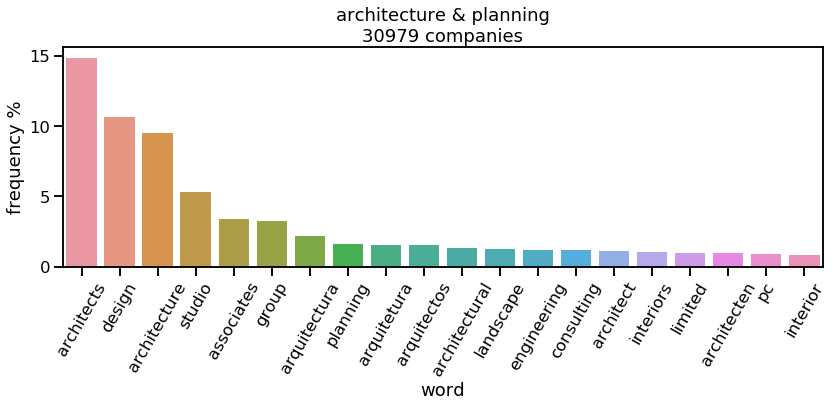

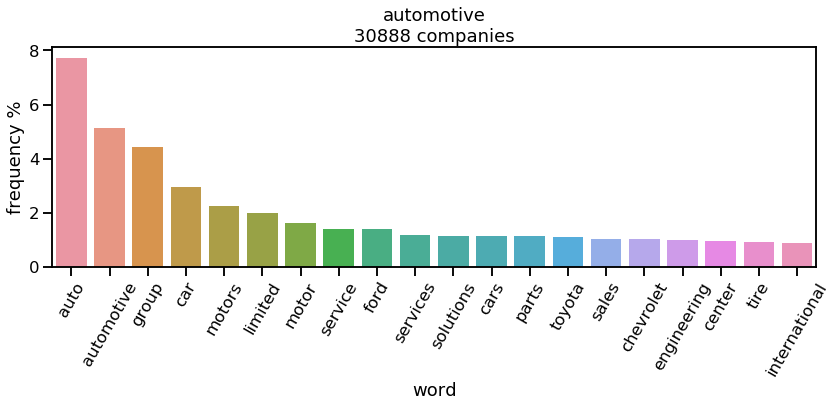

In [24]:
num_words = 20 #number of words to show on the chart

#common words to ignore
ignore_words = ['ltd', 'inc', 'co', 'pvt', 'sl', 'srl', 'ab', 'company', 'bv', 'pty', 'llc', 'pllc', 'gmbh'] 

for industry in top_industries:
    df_industry_words = industry_word_map[industry]
    df_industry_words = df_industry_words[~df_industry_words['word'].isin(ignore_words)]
    plt.figure(figsize=(12,6))
    plt.title(f"{industry}\n{len(df[df['industry']==industry])} companies")
    sns.barplot(data=df_industry_words[0:num_words], x='word', y='frequency %')
    plt.xticks(rotation=60);
    plt.tight_layout();
    plt.savefig(f'./charts_industry_word_bar/{industry} bar chart.png')

#### View word cloud for each industry (can see more words)

In [32]:
def plot_wordcloud(data, title=None, max_words=100, width=500, height=200, filename=None):
    wc = wordcloud.WordCloud(width=width, height=height, max_words=max_words,colormap=None, background_color='White').generate_from_frequencies(data)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(title,fontsize=25)
    if filename:
        plt.savefig(filename)
    plt.show()

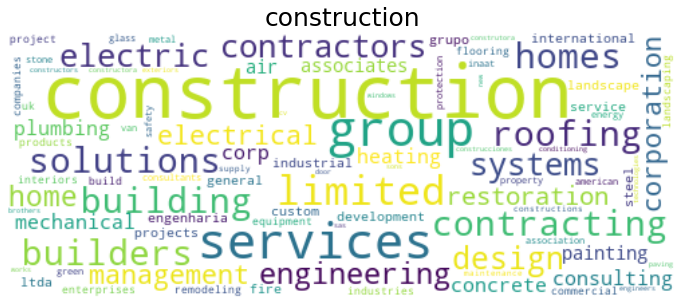

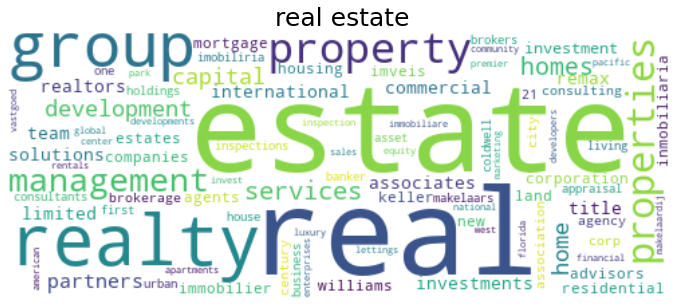

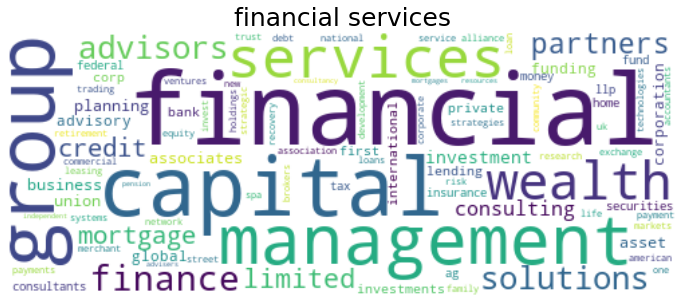

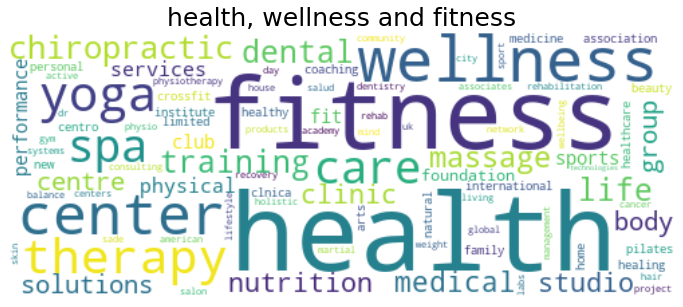

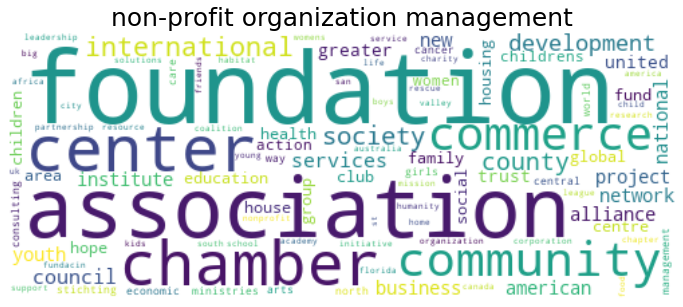

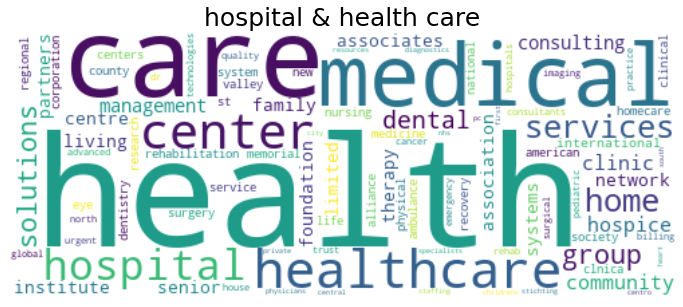

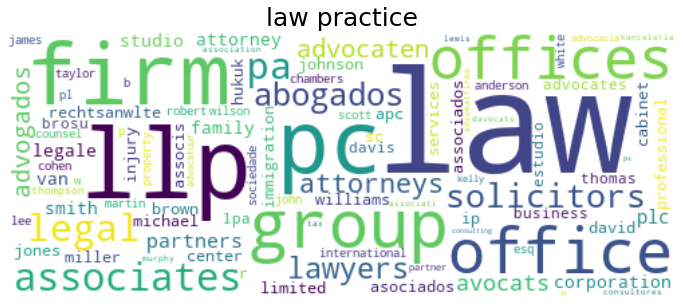

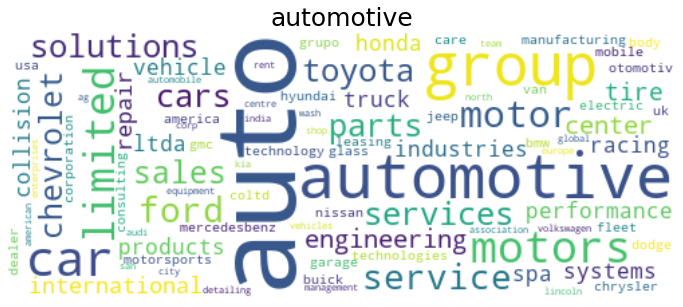

In [35]:
# make word clouds (show more words)
for industry in industry_word_map.keys():
    df_word_map = industry_word_map[industry][['word','frequency']]
    df_word_map = df_word_map[~df_word_map['word'].isin(ignore_words)].set_index('word')['frequency']
    fname = f'./charts_industry_word_clouds/{industry} word cloud.png'
    plot_wordcloud(data=df_word_map, title=industry, max_words=100, filename=fname)

I'm typically not a big fan of word clouds; however, they work nicely in this case to see more information about Company Names by industry.

### Words Common in business names across Industries

Are some words common across multiple industries?

In [456]:
df_industry_words = pd.DataFrame()

for industry in industry_word_map.keys():
    industry_word_map[industry]['industry'] = industry
    df_word_map = industry_word_map[industry]
    df_word_map = df_word_map[~df_word_map['word'].isin(ignore_words)]
    df_industry_words = pd.concat([df_industry_words, df_word_map], axis=0)

#sub-select words that are in at least 1.5% of companies in their respective industry
df_industry_words = df_industry_words[df_industry_words['frequency %']>=1.5]

In [457]:
#create a list of common words that appear in multiple industries
word_counts = df_industry_words['word'].value_counts()
words_in_multiple_industries = list(word_counts[word_counts>1].index)

#Create a dataframe containing only the common words
df_common_words = df_industry_words[df_industry_words['word'].isin(words_in_multiple_industries)]

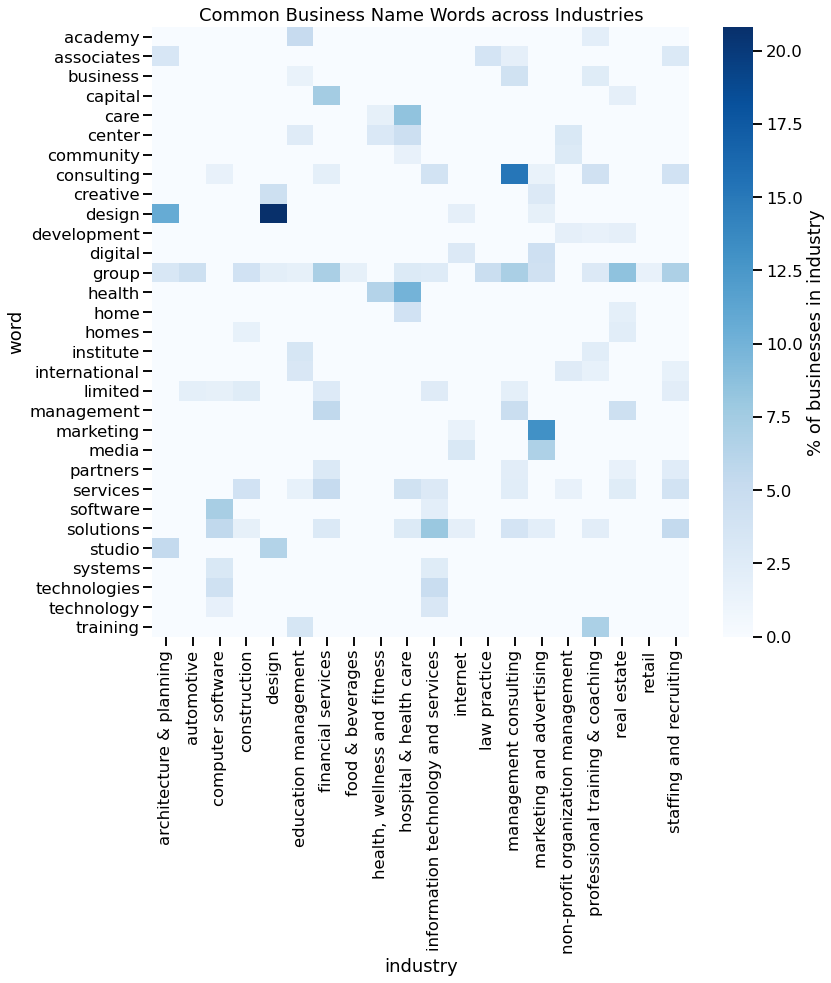

In [461]:
df_common_words_pivoted = df_common_words.pivot(index='word', columns='industry', values='frequency %').fillna(0)
plt.figure(figsize=(12,14))
sns.heatmap(df_common_words_pivoted, cmap='Blues', cbar_kws={'label': '% of businesses in industry'})
plt.title('Common Business Name Words across Industries');
plt.tight_layout()
plt.savefig('Common Business Name Words across Industries.png');

### Words Common in business names but Unique to their Industry

In [462]:
#sub-select words that are in at least 2% of companies in their respective industry
df_industry_words = df_industry_words[df_industry_words['frequency %']>=6]

In [463]:
#create a list of common words that appear in multiple industries
word_counts = df_industry_words['word'].value_counts()
words_in_single_industry = list(word_counts[word_counts==1].index)

#Create a dataframe containing only the common words
df_unique_words = df_industry_words[df_industry_words['word'].isin(words_in_single_industry)]

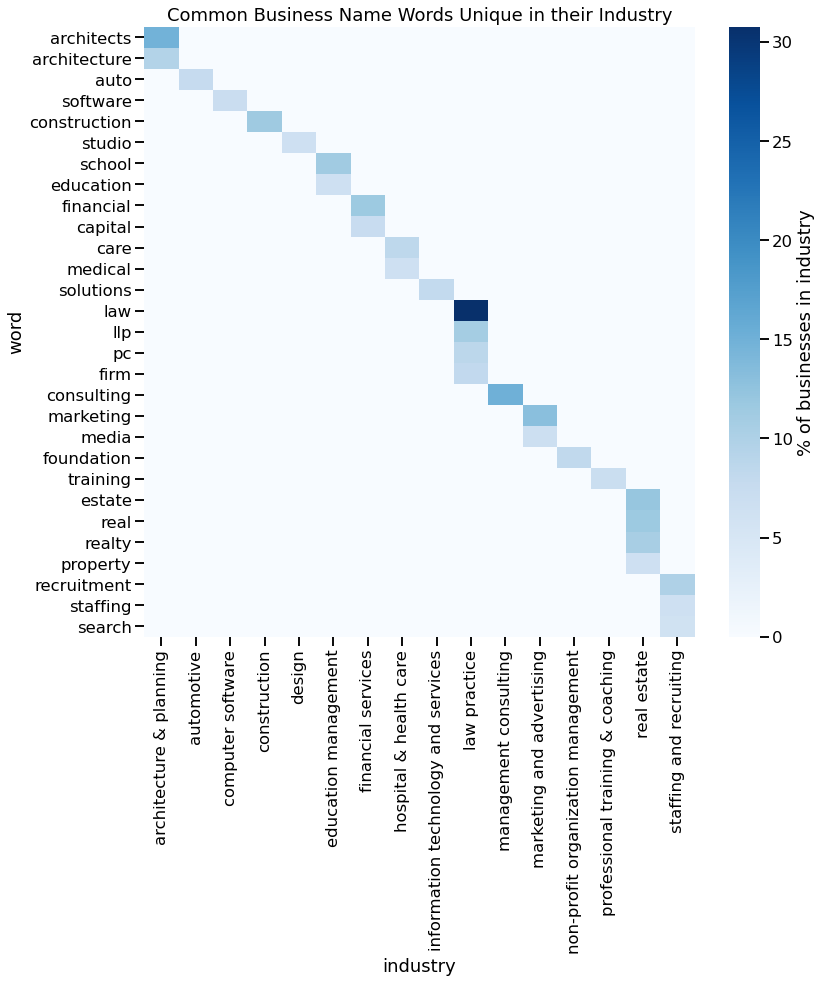

In [466]:
df_unique_words_pivoted = df_unique_words.pivot(index='word', columns='industry', values='frequency %').fillna(0)
columns = list(df_unique_words_pivoted.columns)
df_unique_words_pivoted.sort_values(by=columns, inplace=True, ascending=False)
plt.figure(figsize=(12,14))
sns.heatmap(df_unique_words_pivoted, cmap='Blues', cbar_kws={'label': '% of businesses in industry'})
plt.title('Common Business Name Words Unique in their Industry');
plt.tight_layout()
plt.savefig('Common Business Name Words Unique in their Industry.png');